<a name="rule-based-models"></a>
# Case 1
## [Description]

<span style="font-size:18px;color:blue">

You are asked to play the role of Tier-1 analysts whose responsibilities include analyzing the network flow data and identifying abnormal network events. 

The network flow data contains network flow collected within one week. The network flow data is structured, containing the features:
- Timestamp	
- FlowDuration	
- SrcIP	
- DstIP	
- SrcPort	
- DstPort	
- Protocol	
- TypeofService	
- PacketExed	

You will be provided with two IDS algorithms that can process network flow and identify which network flow is normal or abnormal. There are two models underlying the algorithms:
- [Boolean rule (BR)](#BRCG) 
- [logistic rule regression (LogRR)](#LogRR) 

As an analyst, you would like to understand the behavior of the models as a whole. 
**It means you prefer interpretable models.**
It is notable that the models provide different trade-offs between model simplicity and accuracy in predicting the abnormal network flow. BRCG yields a very simple set of rules that has reasonable accuracy. LogRR achieves higher accuracy, higher even than some uninterpretable models, while retaining the form of a linear model. 
</span>


# [Your Task]


<span style="font-size:18px;color:blue">

    **Make sure you have been assigned a subject ID before you start.**


Your task include:
- Read the case description for each case labeled <b>"[Case Description]"</b> to understand your role in the case
- The cells with the label <b>"[Processing]"</b> show what the IDS algorithms are doing. **You are not asked to rate them.**
- The cells with the label<b>"[IDS Result]"</b> show the IDS system results, for example, the accuracy of the prediction.
- Go through the explainations (highlighed under the title <b>"[Explaination to Rate]"</b>)
- Rate the helpfulness, correctness and the ease of understanding <b>using this <a href="https://utampa.az1.qualtrics.com/jfe/form/SV_bynXokHkn4wNdt3">link</a>.</b>
    - Each explanation can be tracked by its id (for example, EC11)

</span>

### [Processing] Load data

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas

# Load FICO HELOC data with special values converted to np.nan
from aix360.datasets.ugr_dataset import UGRDataset, nan_preprocessing
data = UGRDataset(custom_preprocessing=nan_preprocessing).data()

print(data.shape)
#data.head()

#data.rename( columns={'Unnamed: 0':'ID'}, inplace=True )

data.head()

Using TensorFlow backend.


!!!!!!!!!!!test1
Using UGR dataset2:  /Users/hongliu/AIX360/aix360/datasets/../data/heloc_data/ugr_dataset.csv
(1083605, 10)


,Timestamp,FlowDuration,SrcIP,DstIP,SrcPort,DstPort,Protocol,TypeofService,PacketExed,Label
0,0,0.0,4164106922,719033324,49738,22,1,0.0,0.0,0
1,0,0.0,719034999,1244119783,80,54131,1,0.0,0.0,0
2,0,0.0,719036359,1423064984,3490,2210,1,0.0,0.0,0
3,0,0.0,3554046332,719035603,50163,443,1,0.0,0.0,0
4,0,0.0,2215383230,719032646,39143,1900,2,0.0,0.0,0


In [2]:
# Separate target variable
y = data.pop('Label')

#data.pop('ID')
#data.head()

In [3]:
# Split data into training and test sets using fixed random seed
from sklearn.model_selection import train_test_split
dfTrain, dfTest, yTrain, yTest = train_test_split(data, y, random_state=0, stratify=y)
dfTrain.head().transpose()

,353387,328999,231184,1042242,850874
Timestamp,5.400000e+04,3.600000e+04,3.240000e+04,1.440000e+04,64800.0
FlowDuration,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
SrcIP,3.151986e+09,7.190361e+08,7.190347e+08,3.650895e+09,719034102.0
DstIP,7.190362e+08,2.821066e+09,3.428928e+09,7.190330e+08,719034949.0
SrcPort,8.000000e+01,4.430000e+02,5.300000e+01,5.066000e+03,35646.0
DstPort,5.030000e+04,5.063600e+04,4.905700e+04,7.017000e+03,32768.0
Protocol,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,1.0
TypeofService,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
PacketExed,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0


### [Processing]: Binarizing data


In [4]:
# Binarize data and also return standardized ordinal features
from aix360.algorithms.rbm import FeatureBinarizer
fb = FeatureBinarizer(negations=True, returnOrd=True)
print(fb)
dfTrain, dfTrainStd = fb.fit_transform(dfTrain)
dfTest, dfTestStd = fb.transform(dfTest)
print(dfTrain['SrcIP'].head())


operation           <=                                                      \
value     7.190344e+08 7.190352e+08 7.190357e+08 7.190362e+08 9.615544e+08   
353387               0            0            0            0            0   
328999               0            0            0            1            1   
231184               0            1            1            1            1   
1042242              0            0            0            0            0   
850874               1            1            1            1            1   

operation                                                                >  \
value     2.403863e+09 3.267393e+09 3.605905e+09 3.650895e+09 7.190344e+08   
353387               0            1            1            1            1   
328999               1            1            1            1            1   
231184               1            1            1            1            1   
1042242              0            0            0            1  

### [Processing] Run Boolean Rule Column Generation (BRCG)

In [5]:
# Instantiate BRCG with small complexity penalty and large beam search width
from aix360.algorithms.rbm import BooleanRuleCG
br = BooleanRuleCG(lambda0=1e-3, lambda1=1e-3, CNF=True)

# Train, print, and evaluate model

br.fit(dfTrain, yTrain)


Learning CNF rule with complexity parameters lambda0=0.001, lambda1=0.001


/Users/hongliu/opt/miniconda3/envs/first_AIX/lib/python3.6/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/hongliu/opt/miniconda3/envs/first_AIX/lib/python3.6/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/h

Initial LP solved
Iteration: 1, Objective: 0.1889


/Users/hongliu/opt/miniconda3/envs/first_AIX/lib/python3.6/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/hongliu/opt/miniconda3/envs/first_AIX/lib/python3.6/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/h

Iteration: 2, Objective: 0.1461


/Users/hongliu/opt/miniconda3/envs/first_AIX/lib/python3.6/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/hongliu/opt/miniconda3/envs/first_AIX/lib/python3.6/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/h

Iteration: 3, Objective: 0.1428


/Users/hongliu/opt/miniconda3/envs/first_AIX/lib/python3.6/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/hongliu/opt/miniconda3/envs/first_AIX/lib/python3.6/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/h

Iteration: 4, Objective: 0.1360


/Users/hongliu/opt/miniconda3/envs/first_AIX/lib/python3.6/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/hongliu/opt/miniconda3/envs/first_AIX/lib/python3.6/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/h

Iteration: 5, Objective: 0.1226


/Users/hongliu/opt/miniconda3/envs/first_AIX/lib/python3.6/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/hongliu/opt/miniconda3/envs/first_AIX/lib/python3.6/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/h

Iteration: 6, Objective: 0.1214


/Users/hongliu/opt/miniconda3/envs/first_AIX/lib/python3.6/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/hongliu/opt/miniconda3/envs/first_AIX/lib/python3.6/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/h

Iteration: 7, Objective: 0.1210


/Users/hongliu/opt/miniconda3/envs/first_AIX/lib/python3.6/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/hongliu/opt/miniconda3/envs/first_AIX/lib/python3.6/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/h

Iteration: 8, Objective: 0.1210


/Users/hongliu/opt/miniconda3/envs/first_AIX/lib/python3.6/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/hongliu/opt/miniconda3/envs/first_AIX/lib/python3.6/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/h

## [Explanation to Rate] ID: EC11

<span style="font-size:18px;color:blue">
The IDS (Intrusion Detection System) trained a Boolean Rule Column Generation (BRCG) model to predict normal/abnormal network flow.

The training accuracy and test accuracy are presented below. 

Meanwhile, you are provided with the rules that are used for prediction. **Please rate the following explanation in the survey**. Its id is **EC11**.
</span>

In [6]:
from sklearn.metrics import accuracy_score
print('Training accuracy:', accuracy_score(yTrain, br.predict(dfTrain)))
print('Test accuracy:', accuracy_score(yTest, br.predict(dfTest)))
print('Predict Y=0 (normal network flow) if ANY of the following rules are satisfied, otherwise Y=1 (abnormal network flow):')
print(br.explain()['rules'])

Training accuracy: 0.9004962452458032
Test accuracy: 0.9008755933880148
Predict Y=0 (normal network flow) if ANY of the following rules are satisfied, otherwise Y=1 (abnormal network flow):
['SrcIP > 719036246.00 AND DstPort <= 445.00', 'DstIP > 719036084.00 AND SrcPort <= 25.00', 'SrcIP <= 719035660.00 AND DstIP <= 2403862665.00 AND DstPort <= 80.00', 'Timestamp > 18000.00 AND SrcIP > 719034388.00 AND DstIP <= 719034099.00', 'SrcIP <= 3605905071.00 AND SrcIP > 719034388.00 AND DstIP > 719034686.00 AND SrcPort > 25.00 AND DstPort > 53.00']


In [7]:
print('The IPv4 formats of SrcIP/DstIP are shown below:')

import socket
import struct
def convert_int_ip(ipint):
    #ipint=16909060
    return socket.inet_ntoa(struct.pack('!L', ipint))
    
def convert_ip(ipstr):
    if ipstr.strip == "":
        return 0
    return struct.unpack("!L", socket.inet_aton(ipstr.strip()))[0]


print('The string format of IP 719036092 is ', convert_int_ip(719036092))
print('The string format of IP 953347517 is ', convert_int_ip(953347517))
print('The string format of IP 719036245 is ', convert_int_ip(719036245))
print('The string format of IP 1816330183 is ', convert_int_ip(1816330183))

The IPv4 formats of SrcIP/DstIP are shown below:
The string format of IP 719036092 is  42.219.158.188
The string format of IP 953347517 is  56.210.237.189
The string format of IP 719036245 is  42.219.159.85
The string format of IP 1816330183 is  108.66.255.199


### [Processing] Run Logistic Rule Regression (LogRR)


In [8]:
# Instantiate LRR with good complexity penalties and numerical features
from aix360.algorithms.rbm import LogisticRuleRegression
lrr = LogisticRuleRegression(lambda0=0.005, lambda1=0.001, useOrd=True)

# Train, print, and evaluate model
lrr.fit(dfTrain, yTrain, dfTrainStd)



/Users/hongliu/opt/miniconda3/envs/first_AIX/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/hongliu/AIX360/aix360/algorithms/rbm/beam_search.py:58: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  zOut = pd.Series(index=X.columns)
/Users/hongliu/opt/miniconda3/envs/first_AIX/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/hongliu/AIX360/aix360/algorithms/rbm/beam_search.py:58: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  zOut = pd.Series(i

## [Explanation to Rate] ID: EC12

<span style="font-size:18px;color:blue">
The IDS (Intrusion Detection System)  trained a Logistic Rule Regression (LogRR) model to predict normal/abnormal network flow.

The training accuracy and test accuracy are presented below. 

Meanwhile, you are provided with the rules that are used for prediction. **Please rate the following explanation in the survey**. Its id is **EC12**
</span>

In [9]:
print('Training accuracy:', accuracy_score(yTrain, lrr.predict(dfTrain, dfTrainStd)))
print('Test accuracy:', accuracy_score(yTest, lrr.predict(dfTest, dfTestStd)))


print('Probability of Y=1 (abnormal netowrk flow) is predicted as logistic(z) = 1 / (1 + exp(-z))')
print('where z is a linear combination of the following rules/numerical features:')
lrr.explain()

Training accuracy: 0.8806550486463074
Test accuracy: 0.8800377996471048
Probability of Y=1 (abnormal netowrk flow) is predicted as logistic(z) = 1 / (1 + exp(-z))
where z is a linear combination of the following rules/numerical features:


,rule/numerical feature,coefficient
0,(intercept),-1.06882
1,SrcIP > 719036246.00 AND SrcPort > 25.00 AND P...,-5.3475
2,SrcIP <= 3605905071.00 AND DstPort > 53.00 AND...,-3.43895
3,SrcIP <= 3605905071.00 AND SrcIP > 719034388.0...,-3.1256
4,FlowDuration <= 0.00 AND SrcIP <= 3605905071.0...,-2.90842
5,DstIP <= 3382760901.00 AND DstIP > 719034099.0...,2.8578
6,SrcIP <= 3650894805.00 AND DstPort <= 19067.00...,2.6398
7,Timestamp > 10800.00 AND DstIP <= 3382760901.0...,1.95925
8,SrcIP <= 3605905071.00,1.8776
9,SrcIP <= 3650894805.00 AND DstIP <= 1034903133...,1.85743


## [Explanation to Rate] ID: EC13

<span style="font-size:18px;color:blue">

The plots below show the sizes and shapes of the model's dependences on individual features. These can then be compared to a lending expert's knowledge. In the present case, all plots indicate that the model behaves as we would expect with some interesting nuances. 

- Please go through the following several plots that shows the sizes and shapes of the model's dependaences on individual features. 
- Rate them in general in the survey. The id is **EC13**
    
</span>

In [22]:
dfx = lrr.explain()
#print(dfx)
# Separate 1st-degree rules into (feature, operation, value) to count unique features
#dfx2 = dfx['rule/numerical feature'].str.split(' ', expand=True)
dfx2 = dfx['rule/numerical feature'].str.split(' ', expand=True)
#print(dfx2)
dfx2.columns = ['feature1','operation','value', 'connector', 
                'feature2', 'operation', 'value', 'connector', 
                'feature3', 'operation', 'value',  'connector', 
                'feature4', 'operation', 'value',  'connector', 
                'feature5', 'operation', 'value',  'connector', 
                'feature6', 'operation', 'value',  'connector', 
                'feature7', 'operation', 'value',  'connector', 
                'feature8', 'operation', 'value',  'connector', 
                'feature9', 'operation', 'value']
#print(dfx2['feature1'].nunique())# includes intercept
#print(dfx2['feature2'].nunique())# includes intercept

print(lrr)

LogisticRuleRegression(lambda0=0.005, lambda1=0.001, useOrd=True)


It follows that there are several functions to plot, which we organize into semantic groups below to ease interpretation.

/Users/hongliu/AIX360/aix360/algorithms/rbm/logistic_regression.py:351: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  terms = pd.Series(index=pd.MultiIndex.from_arrays([[],[],[]], names=self.z.index.names))


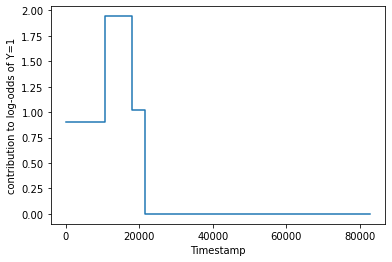

In [12]:
lrr.visualize(data, fb, ['Timestamp']);

/Users/hongliu/AIX360/aix360/algorithms/rbm/logistic_regression.py:351: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  terms = pd.Series(index=pd.MultiIndex.from_arrays([[],[],[]], names=self.z.index.names))


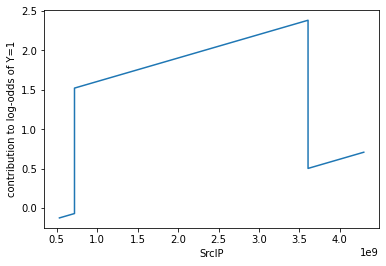

In [13]:
lrr.visualize(data, fb, ['SrcIP']);


/Users/hongliu/AIX360/aix360/algorithms/rbm/logistic_regression.py:351: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  terms = pd.Series(index=pd.MultiIndex.from_arrays([[],[],[]], names=self.z.index.names))


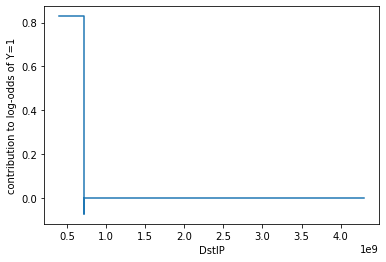

In [14]:
lrr.visualize(data, fb, ['DstIP']);

/Users/hongliu/AIX360/aix360/algorithms/rbm/logistic_regression.py:351: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  terms = pd.Series(index=pd.MultiIndex.from_arrays([[],[],[]], names=self.z.index.names))


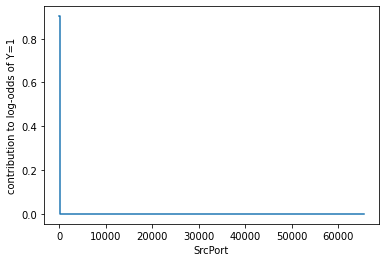

In [15]:
lrr.visualize(data, fb, ['SrcPort']);

/Users/hongliu/AIX360/aix360/algorithms/rbm/logistic_regression.py:351: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  terms = pd.Series(index=pd.MultiIndex.from_arrays([[],[],[]], names=self.z.index.names))


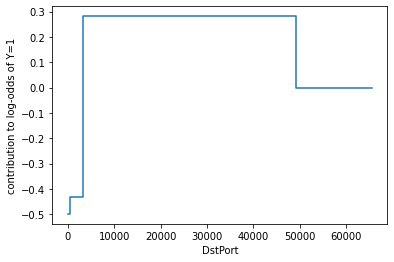

In [16]:
lrr.visualize(data, fb, ['DstPort']);

In [17]:
lrr.visualize(data, fb, ['Protocol']);


/Users/hongliu/AIX360/aix360/algorithms/rbm/logistic_regression.py:351: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  terms = pd.Series(index=pd.MultiIndex.from_arrays([[],[],[]], names=self.z.index.names))


In [18]:
lrr.visualize(data, fb, ['TypeofService']);

In [19]:
lrr.visualize(data, fb, ['PacketExed']);

## Thank you for completing the task. Please submit the evaluation survey. 